In [1]:
import khmer
# ref = https://github.com/dib-lab/khmer/blob/master/examples/python-api/exact-counting.py
import tqdm
import pandas as pd
import numpy as np
import os, glob, subprocess
import scanpy.api as sc
import anndata as ad
from scipy import sparse
from plotnine import *
import plotnine
from IPython.core.display import HTML

def file_len(fname):
    with open(fname) as f:
        for i, l in enumerate(f):
            pass
    return i + 1

# filter completed samples
def find_completed (results_dir, dir_path, target_suffix):
    fa_list = []
    blastOut_list = []

    # check for completed files: *_geneCounts.csv
    for outfile in glob.glob(f'{results_dir}*/*_geneCounts.csv'):
        with open(outfile, 'r') as out_f:
            deduce_cell_id = outfile.split('/')[-2]
        deduce_target = f'{dir_path}{deduce_cell_id}{target_suffix}'
        deduce_out = f'{results_dir}{deduce_cell_id}/{deduce_cell_id}_blastpOut.txt'
        fa_list = fa_list + [deduce_target]
        blastOut_list = blastOut_list + [deduce_out]
    return fa_list, blastOut_list

def process_blastp_results(target_output, results_dir, evalue_cutoff):
    # ingest table
    results = pd.read_csv(target_output, 
                          sep = '\t',
                          header = None
                         )
    results.columns = ['qsid' , 'ssid', 'evalue']
    # parse frame and ids
    results['frame'] = [x.split('__')[-1][-1] for x in results['qsid']]
    results['qsid'] = [x.split('__')[0] for x in results['qsid']]
    results['uniprot'] = [x.split('|')[1] for x in results['ssid']]
    results['common_name'] = [x.split('|')[2] for x in results['ssid']]
    # return best-match frame
    results = results.sort_values('evalue', ascending = True).groupby(['qsid']).head(1)
    # filter results to significant matches
    results = results[results.evalue < evalue_cutoff]
    # adjust df to merge
    results = (results
               .loc[:,['uniprot','qsid']]
               .rename(columns = {'qsid':'seq_id'})
              )

    # ingest uniprot to symbol df for lookup
    scope2field_df = pd.read_csv(f'{results_dir}scope2field.csv',index_col = 0)
    results = pd.merge(scope2field_df,
                       results,
                       'inner',
                       'uniprot'
                      )
    results = results.drop('uniprot', axis = 1)
               
    return results


In [10]:
# identify input data
input_dir = '/home/ubuntu/data/longread/test_dir/multi_species/'
fa_list = glob.glob(f'{input_dir}*.fa')
entry_len_list = []
for fn in fa_list:
    entry_len_list = entry_len_list+[int(file_len(fn)/2)]
balanced_entry_len_sum = np.sum(entry_len_list)


In [3]:
# kmerize
ksize = 8
nkmers = 4**ksize

cell_df = pd.DataFrame()
master_df = pd.DataFrame()
kmer_arr = np.zeros((nkmers, balanced_entry_len_sum))

arr_idx = 0
seq_id_arr = np.zeros((balanced_entry_len_sum), dtype = 'object')
cell_id_arr = np.zeros((balanced_entry_len_sum), dtype = 'object')

# ingest all .fa files from dir
for fn in fa_list:
    # extract fn prefix for cell id
    cell_id = fn.split('/')[-1].split('.fa')[0]

    with open(fn, 'r') as f:

        # parse entry by entry
        for count, line in tqdm.tqdm(enumerate(f, start=0)):   

            # extract first line as seq id
            if count % 2 == 0:
                k_name = line[1:-1]

            # extract second line as sequence
            if count % 2 != 0:

                # Initialize countgraph
                tablesize = nkmers + 10
                ktable = khmer.Countgraph(ksize, tablesize, 1)

                # count all k-mers in the given string
                ktable.consume(line[:-1])

                # capture full kmer counts
                k_n_list = [ktable.get(i) for i in range(nkmers)]

                # update kmer count arr
                kmer_arr[:,arr_idx] = k_n_list 

                # log sequence and cell names for metadata
                seq_id_arr[arr_idx] = k_name
                cell_id_arr[arr_idx] = cell_id

                # update arr pointer
                arr_idx = arr_idx + 1

# create dfs
kmers_list = [ktable.reverse_hash(i) for i in range(nkmers)]
master_df = pd.DataFrame(kmer_arr)
master_df['kmers'] = kmers_list
master_df = master_df.set_index('kmers')
master_df.columns = seq_id_arr.tolist()
master_df = master_df.astype(int)
cell_df = pd.DataFrame({'seq_id':seq_id_arr,
                        'cell_id':cell_id_arr,
                       })
cell_df = cell_df.set_index('seq_id')


400it [00:02, 134.32it/s]
400it [00:02, 137.49it/s]
400it [00:02, 140.68it/s]


In [4]:
# ingest data to adata obj

# pd df to np array
array_adata = master_df.values

# extract obs and var
obs = master_df.columns.tolist()
gene_names = master_df.index.tolist()

# create ad obj
adata = ad.AnnData(X=array_adata).T
adata.X = sparse.csr_matrix(adata.X)
adata.var_names = gene_names
adata.obs_names = obs

# append metadata
adata.obs['cell_id'] = cell_df.cell_id.tolist()

# transform and freeze raw state
adata.raw = sc.pp.log1p(adata, copy=True)

# embed and cluster
n_pcs = 200
n_neighbs = 10
min_dist = 0.3

all_forms_adata = sc.pp.log1p(adata, copy=True) 
sc.pp.scale(all_forms_adata) 
sc.tl.pca(all_forms_adata, use_highly_variable = False, n_comps=n_pcs, random_state=1) 
sc.pp.neighbors(all_forms_adata, n_pcs=n_pcs, n_neighbors = n_neighbs, random_state=1) 
sc.tl.umap(all_forms_adata, min_dist = min_dist, random_state=1)


/home/ubuntu/anaconda3/lib/python3.7/site-packages/umap/umap_.py:349: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "fuzzy_simplicial_set" failed type inference due to: Untyped global name 'nearest_neighbors': cannot determine Numba type of <class 'function'>

File "../../anaconda3/lib/python3.7/site-packages/umap/umap_.py", line 467:
def fuzzy_simplicial_set(
    <source elided>
    if knn_indices is None or knn_dists is None:
        knn_indices, knn_dists, _ = nearest_neighbors(
        ^

  @numba.jit()
/home/ubuntu/anaconda3/lib/python3.7/site-packages/numba/compiler.py:725: NumbaWarning: Function "fuzzy_simplicial_set" was compiled in object mode without forceobj=True.

File "../../anaconda3/lib/python3.7/site-packages/umap/umap_.py", line 350:
@numba.jit()
def fuzzy_simplicial_set(
^

  self.func_ir.loc))
/home/ubuntu/anaconda3/lib/python3.7/site-packages/numba/compiler.py:734: NumbaDeprecationWarning: 
Fall-back from the nop

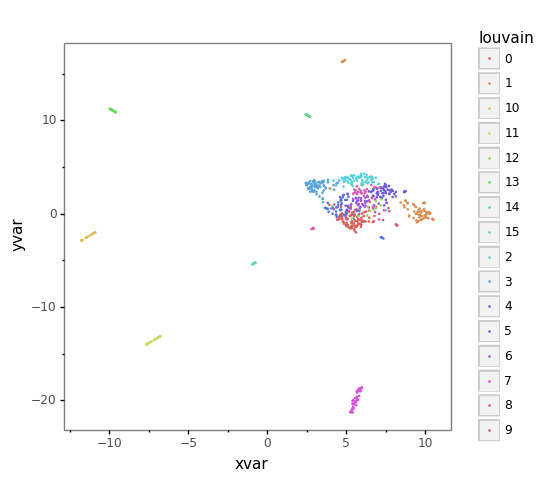

<ggplot: (8779009824141)>


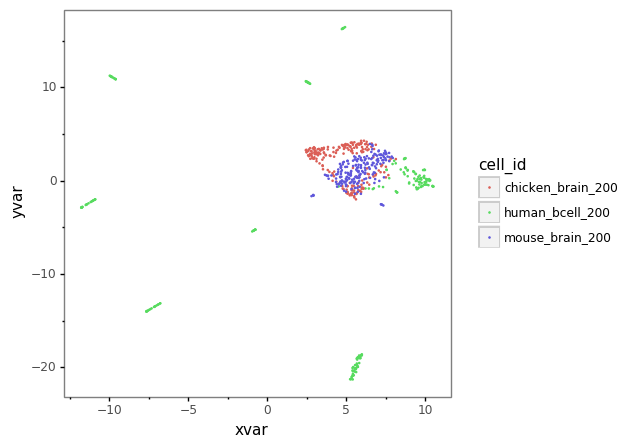

<ggplot: (8779018073292)>


In [5]:
louvain_res = 2
sc.tl.louvain(all_forms_adata, resolution = louvain_res, random_state=1)

umap_df = pd.DataFrame(all_forms_adata.obsm['X_umap'], columns = ['xvar','yvar'])
umap_df['cell_id'] = all_forms_adata.obs.cell_id.tolist()
umap_df['seq_id'] = all_forms_adata.obs.index.tolist()
umap_df['louvain'] = all_forms_adata.obs.louvain.tolist()

plotnine.options.figure_size = (5,5)
for val in ['louvain','cell_id']:
    plot = (ggplot(umap_df)
            + theme_bw()
            + theme(aspect_ratio = 1,
                    panel_grid_major = element_blank(), 
                    panel_grid_minor = element_blank()
                   )
            + geom_point(aes('xvar','yvar',color=val), 
                         size=0.05)

           )
    print(plot)


In [17]:
def translate(seq, frame=1): 
    # frame: 1 = start at pos 0; 2 = start at pos 1; 3 = start at pos 2
    table = { 
        'ATA':'I', 'ATC':'I', 'ATT':'I', 'ATG':'M', 
        'ACA':'T', 'ACC':'T', 'ACG':'T', 'ACT':'T', 
        'AAC':'N', 'AAT':'N', 'AAA':'K', 'AAG':'K', 
        'AGC':'S', 'AGT':'S', 'AGA':'R', 'AGG':'R',                  
        'CTA':'L', 'CTC':'L', 'CTG':'L', 'CTT':'L', 
        'CCA':'P', 'CCC':'P', 'CCG':'P', 'CCT':'P', 
        'CAC':'H', 'CAT':'H', 'CAA':'Q', 'CAG':'Q', 
        'CGA':'R', 'CGC':'R', 'CGG':'R', 'CGT':'R', 
        'GTA':'V', 'GTC':'V', 'GTG':'V', 'GTT':'V', 
        'GCA':'A', 'GCC':'A', 'GCG':'A', 'GCT':'A', 
        'GAC':'D', 'GAT':'D', 'GAA':'E', 'GAG':'E', 
        'GGA':'G', 'GGC':'G', 'GGG':'G', 'GGT':'G', 
        'TCA':'S', 'TCC':'S', 'TCG':'S', 'TCT':'S', 
        'TTC':'F', 'TTT':'F', 'TTA':'L', 'TTG':'L', 
        'TAC':'Y', 'TAT':'Y', 'TAA':'', 'TAG':'', 
        'TGC':'C', 'TGT':'C', 'TGA':'', 'TGG':'W', 
    } 
    comp_dict = {'C':'G',
                 'G':'C',
                 'A':'T',
                 'T':'A'
                }
    protein = ''
    
    if frame == 1 :
        start_val = 0
    if frame == 2:
        start_val = 1
    if frame == 3:
        start_val = 2
    if frame == 4 :
        start_val = 0
    if frame == 5:
        start_val = 1
    if frame == 6:
        start_val = 2
    if frame > 3:
        seq = ''.join([comp_dict.get(x) for x in seq])
        
    for i in range(start_val, len(seq), 3): 
        try:
            codon = seq[i:i + 3] 
            protein+= table[codon] 
        except:
            break
    return protein


In [41]:
sample_n = 10
input_dir = '/home/ubuntu/data/longread/test_dir/multi_species/'
out_dir = '/home/ubuntu/data/longread/test_dir/multi_species/outputs/'

for cluster_oi in list(set(all_forms_adata.obs.louvain)):
    cluster_slice = all_forms_adata[all_forms_adata.obs.louvain == cluster_oi]
    fn_oi = cluster_slice.obs.cell_id.tolist()[:sample_n]
    entry_oi = cluster_slice.obs.index.tolist()[:sample_n]
    
    outfile = f'{out_dir}cluster_{cluster_oi}.fa'
    for fn, entry in zip([f'{input_dir}{x}.fa' for x in fn_oi],
                         entry_oi
                        ):
        # extract fn prefix for cell id
        cell_id = fn.split('/')[-1].split('.fa')[0]

        with open(fn, 'r') as f:

            # parse entry by entry
            for count, line in enumerate(f, start=0):   

                # extract first line as seq id
                if count % 2 == 0:
                    k_name = line[1:-1].split(' ')[0]

                # extract second line as sequence
                if count % 2 != 0 and k_name == entry.split(' ')[0]:
                    for frame in [1,2,3,4,5,6]:
                        seq = translate(line[:-1],frame)
                        with open(outfile, 'a') as outf:
                            outf.write(f'>{k_name}_fr{frame}\n{seq}\n')


f75509d9-1c9f-4efc-a5df-6b63a99d4079_13.05_7783_3_2414_2030
520e9242-292c-4754-8d3f-a759ed3fac30_11.54_20533_9_2057_1670
95e7895c-0eea-444e-8c73-be56889698d3_11.02_8925_3_2046_1660
8715db8a-84bb-4259-9fcf-82d566264e22_9.19_37267_17_2225_1709
351d9ec7-8faf-4a84-a744-a23bdbbbbef4_9.13_11827_5_2072_1690
cbb3f635-9d73-4e10-a5fc-66281ed8a3a2_9.92_6070_2_2032_1657
757057e2-5bc4-4f11-950b-f051e6e7cbcb_10.54_12911_5_2079_1681
d4132711-cb63-480f-90bc-2c6ac529c8ad_11.17_4162_1_2037_1675
ERR1346030.49232
SRR7652917.71661
ERR1346030.2643
ERR1346030.54593
ERR1346030.29668
ERR1346030.78102
ERR1346030.121564
ERR1346030.142835
ERR1346030.114408
ERR1346030.91391
SRR7652917.184542
SRR7652917.655673
1fea3012-96bf-4c57-af95-10984b113a80_11.21_29375_7_3782_3391
89ae8270-65ba-4c07-8631-e0deaa0697bf_12.8_6563_1_3472_3114
ad5504ac-dd78-4290-9523-6f3dbe5b3d38_11.71_8036_4_1832_1426
8026fb3d-313e-463b-b2b6-232e5ae1f396_10.6_12010_2_3723_3329
1b8bcdde-e5b1-4dfd-87be-bdee642af402_11.97_10666_5_1790_1387
e697e0ae-

In [42]:
def run_blastp(input_fn, prot_ref, n_threads, ouput_fn, log_fn):
    # run blast
    blast_cmd_list = ['blastp',
                      '-query',
                      input_fn,
                      '-db',
                      prot_ref,
                      '-matrix',
                      'BLOSUM45',
                      '-outfmt',
                      '"6 evalue qseqid sseqid"',
                      '-max_target_seqs',
                      '1',
                      '-num_threads',
                      f'{n_threads}',
                      '-out',
                      ouput_fn,
                     ]
    blast_cmd = ' '.join(blast_cmd_list)
    print(blast_cmd)
    subprocess.call(blast_cmd, shell=True)
    with open(log_fn, 'a') as outf:
        outf.write(f'{input_fn}\n')
    

In [43]:
prot_ref = '/home/ubuntu/data/longread/proteome/UP000005640_9606.fasta'
n_threads = 8
log_fn = '/home/ubuntu/data/longread/test_dir/multi_species/outputs/blast_results/log.txt'

for blast_targets in glob.glob(f'{out_dir}*.fa'):
    prefix = blast_targets.split('/')[-1].split('.')[0]
    ouput_fn = f'/home/ubuntu/data/longread/test_dir/multi_species/outputs/blast_results/{prefix}_blast.tsv'
    run_blastp(blast_targets, prot_ref, n_threads, ouput_fn, log_fn)
    

blastp -query /home/ubuntu/data/longread/test_dir/multi_species/outputs/cluster_15.fa -db /home/ubuntu/data/longread/proteome/UP000005640_9606.fasta -matrix BLOSUM45 -outfmt "6 evalue qseqid sseqid" -max_target_seqs 1 -num_threads 8 -out /home/ubuntu/data/longread/test_dir/multi_species/outputs/blast_results/cluster_15_blast.tsv
blastp -query /home/ubuntu/data/longread/test_dir/multi_species/outputs/cluster_5.fa -db /home/ubuntu/data/longread/proteome/UP000005640_9606.fasta -matrix BLOSUM45 -outfmt "6 evalue qseqid sseqid" -max_target_seqs 1 -num_threads 8 -out /home/ubuntu/data/longread/test_dir/multi_species/outputs/blast_results/cluster_5_blast.tsv
blastp -query /home/ubuntu/data/longread/test_dir/multi_species/outputs/cluster_10.fa -db /home/ubuntu/data/longread/proteome/UP000005640_9606.fasta -matrix BLOSUM45 -outfmt "6 evalue qseqid sseqid" -max_target_seqs 1 -num_threads 8 -out /home/ubuntu/data/longread/test_dir/multi_species/outputs/blast_results/cluster_10_blast.tsv
blastp -q

In [ ]:
# begin blasting
    args_tuples = []
    for sample in sample_list:
        args_tuples = args_tuples + [(sample,
                                     target_suffix,
                                     frames,
                                     ref_path,
                                     results_dir,
                                     6,
                                     evalue_cutoff
                                     )]
    p = multiprocessing.Pool(processes=n_threads)
    try:
        p.starmap(run_blast, args_tuples)
    finally:
        p.close()
        p.join()